# Single-molecule intensity time-traces test

In [1]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context
import pandas as pd

data = (DatasetPool(path='./../../BACMMAN_datasets',
                    dsList='240620_2',
                    groups='30 ng/ml',
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        )

Dataset 240620_2 (group 3): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid', 'SM_traces']


In [5]:
data.SM_traces.head()

,Position,PositionIdx,Indices,Frame,Idx,Time,RecB_intensity,TrackHeadIndices,TrackLength,TrackObjectCount,ParentTrackHeadIndices,TrackErrorNext,TrackErrorPrev,Prev,Next,Dataset,Group,ParentIndices
0,Im008,0,0-8-0,0,0,0.0,6676.22,0-8-0,11,11,0-8,False,False,NaN,1-8-1,240620_2,3,0-8
1,Im008,0,0-12-0,0,0,0.0,7380.78,0-12-0,12,12,0-12,False,False,NaN,1-12-1,240620_2,3,0-12
2,Im008,0,0-25-0,0,0,0.0,7634.11,0-25-0,12,12,0-25,False,False,NaN,1-25-0,240620_2,3,0-25
3,Im008,0,0-32-0,0,0,0.0,9801.14,0-32-0,41,41,0-32,False,False,NaN,1-32-0,240620_2,3,0-32
4,Im008,0,0-38-0,0,0,0.0,9177.11,0-38-0,13,13,0-38,False,False,NaN,1-38-0,240620_2,3,0-38


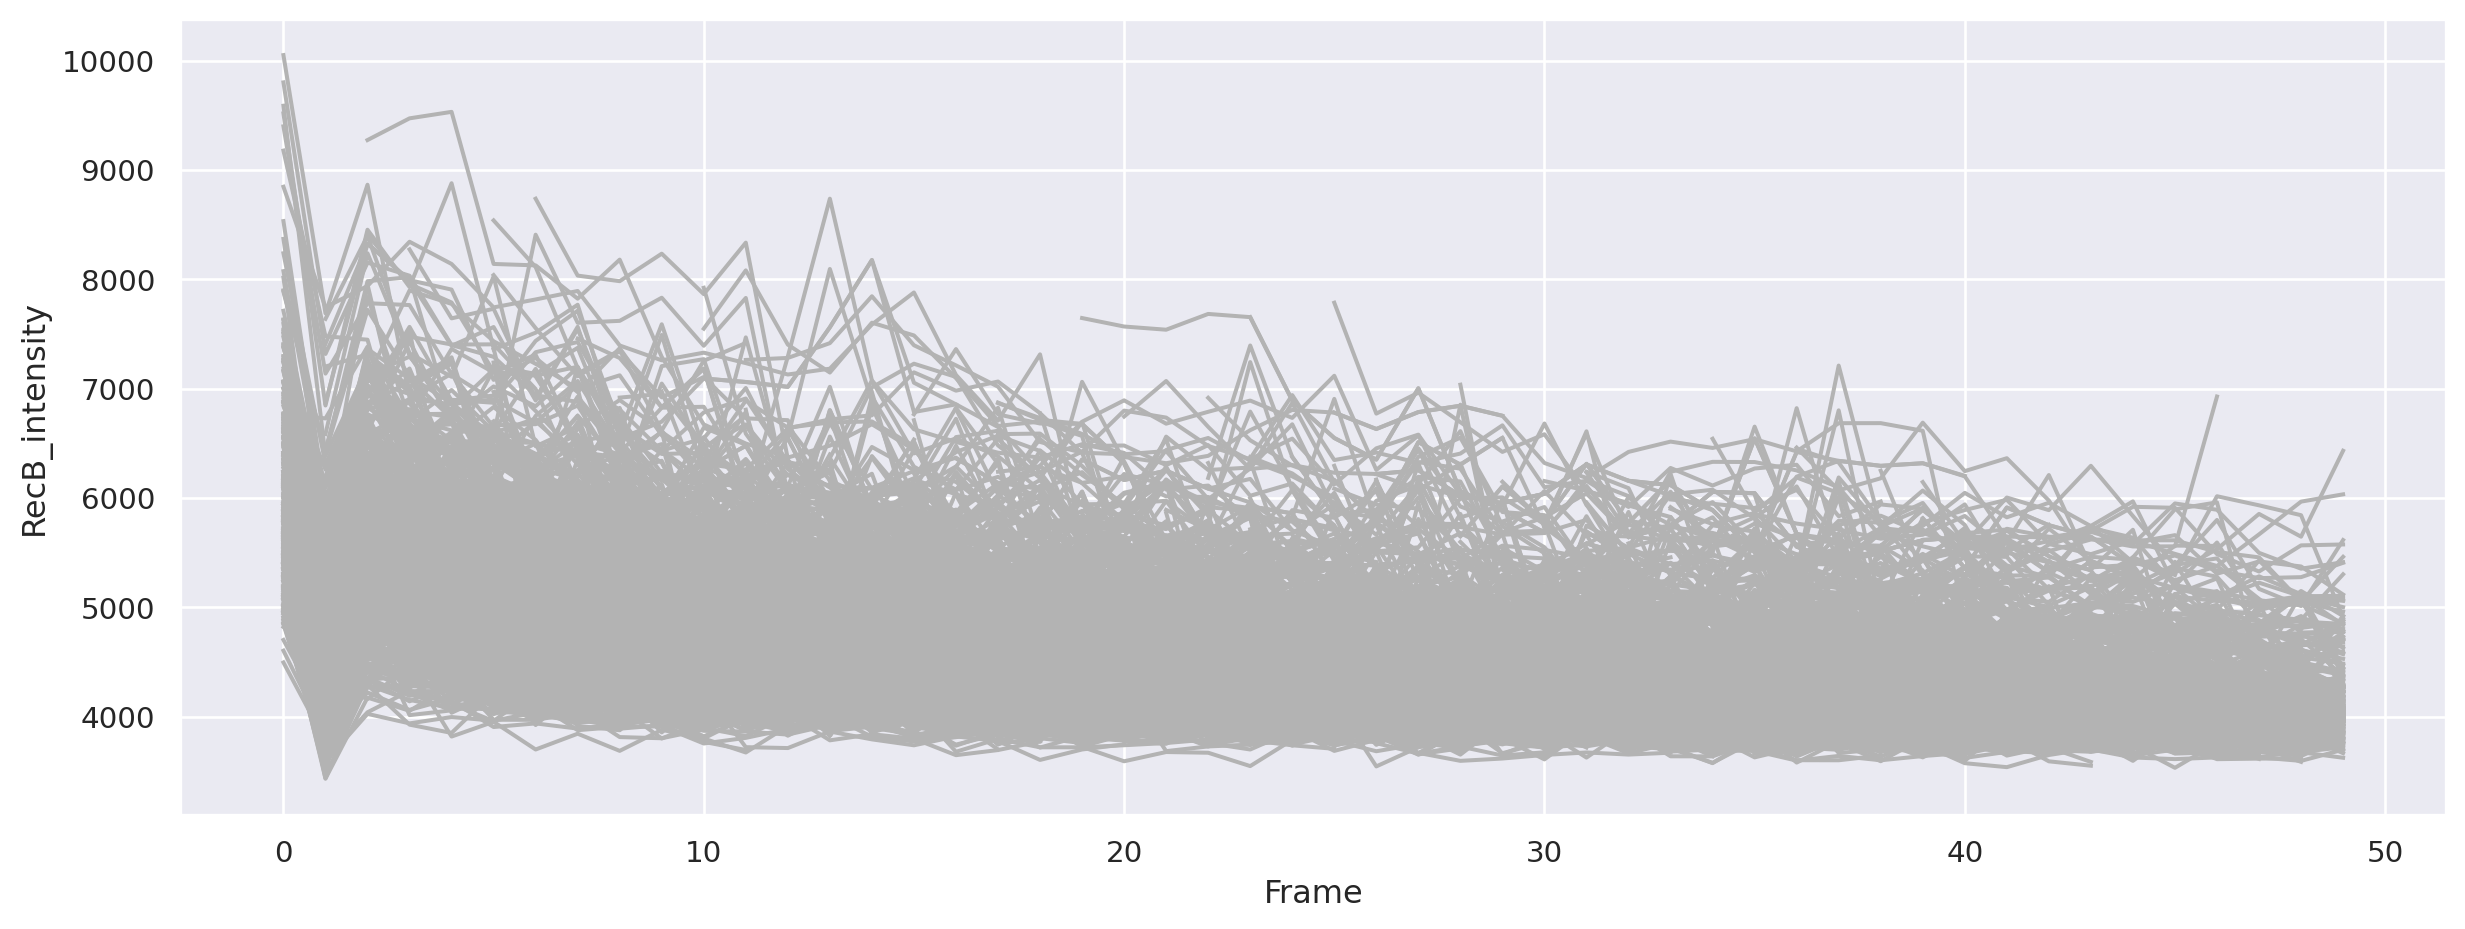

In [7]:
df = (data
      .fuse_columns(object_name='SM_traces', columns=['Dataset', 'Position', 'TrackHeadIndices'], new='spotID')
      .SM_traces
      .query('TrackLength >= 10')
      )



(
    so.Plot(df, x='Frame', y='RecB_intensity', group='spotID')
    .layout(size=(13,5))
    .add(so.Lines(color='.7'), legend=False)
)

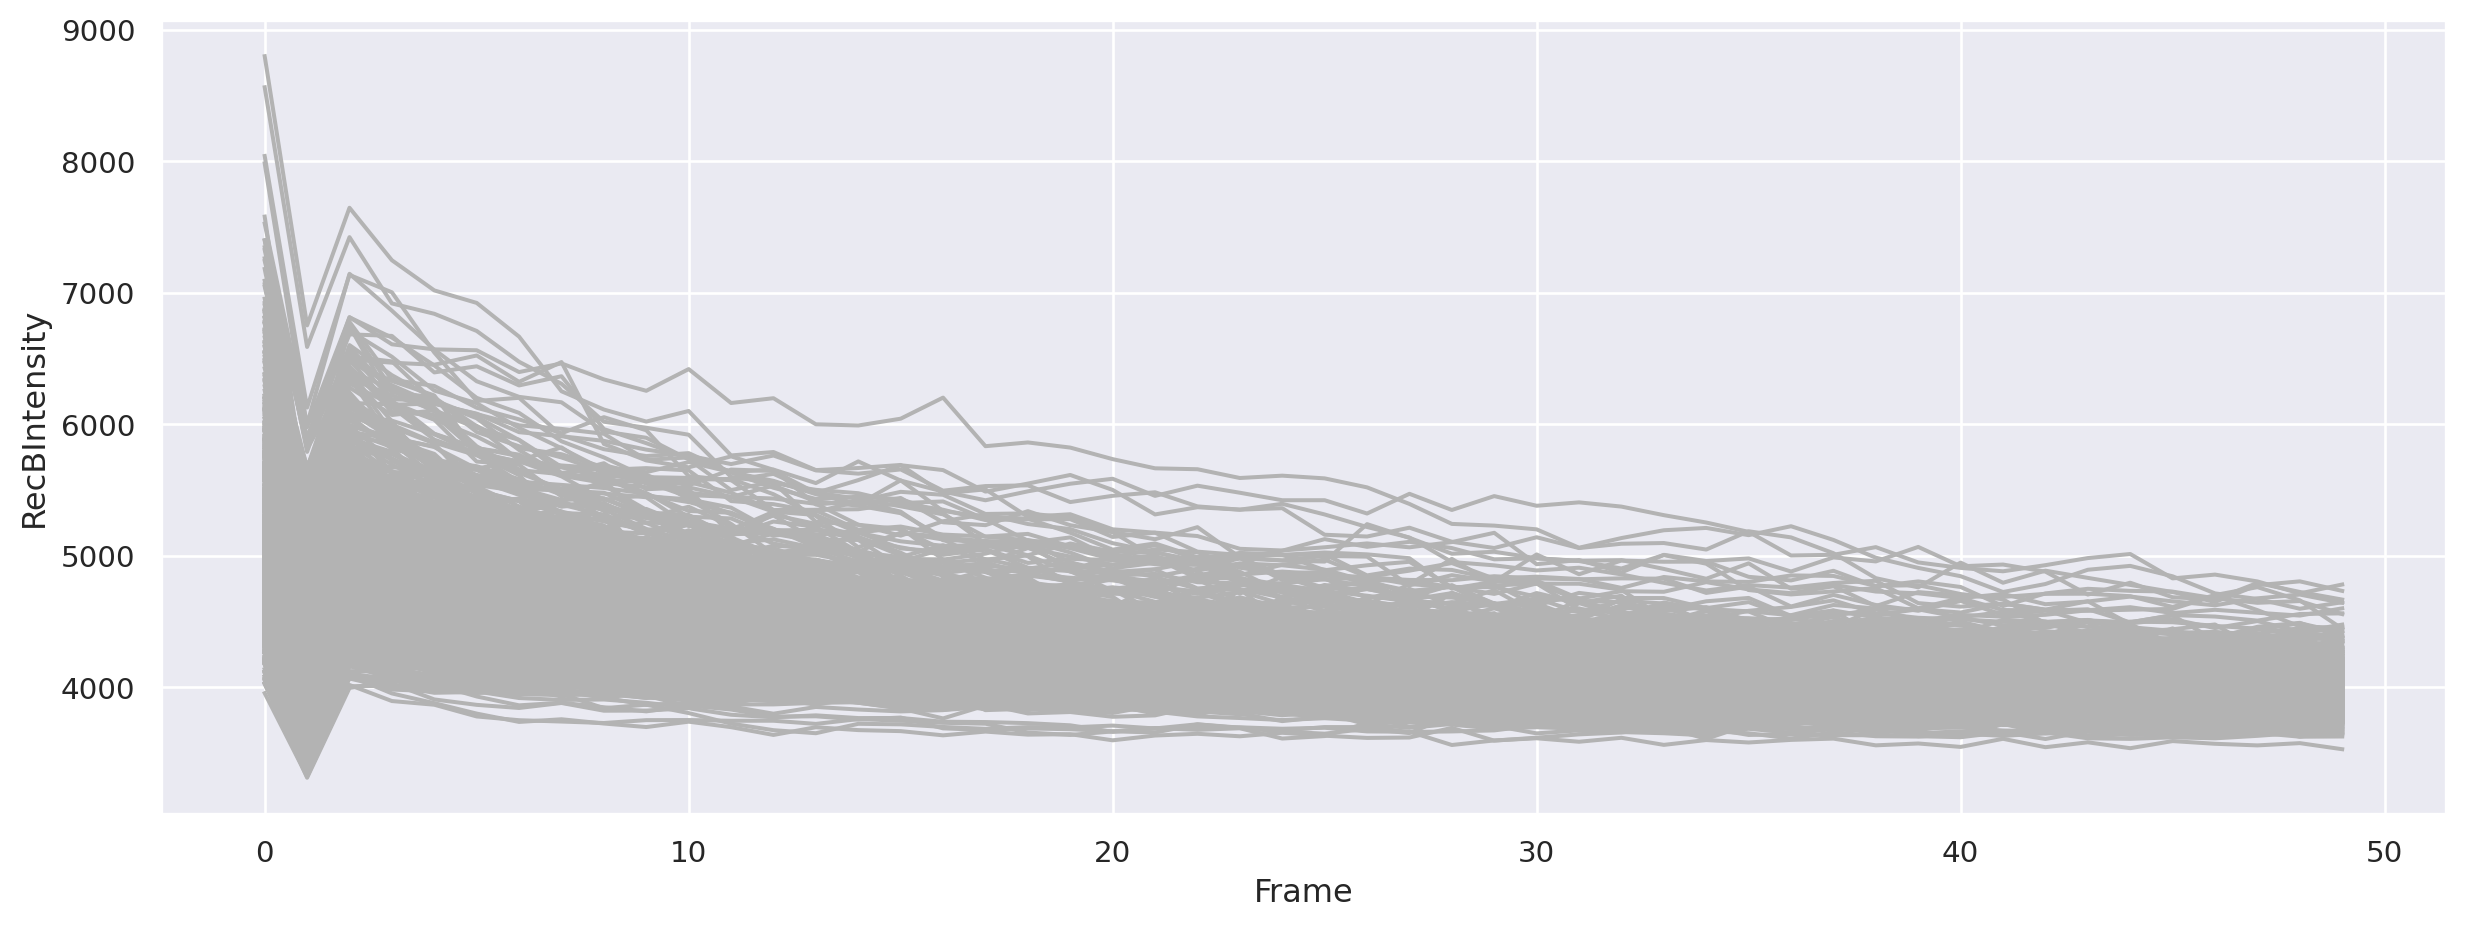

In [29]:
df = (data
      .fuse_columns(object_name='Bacteria_large', columns=['Dataset', 'Position', 'Idx'], new='cellID')
      .Bacteria_large
      )

(
    so.Plot(df, x='Frame', y='RecBIntensity', group='cellID')
    .layout(size=(13,5))
    .add(so.Lines(color='.7'), legend=False)
)

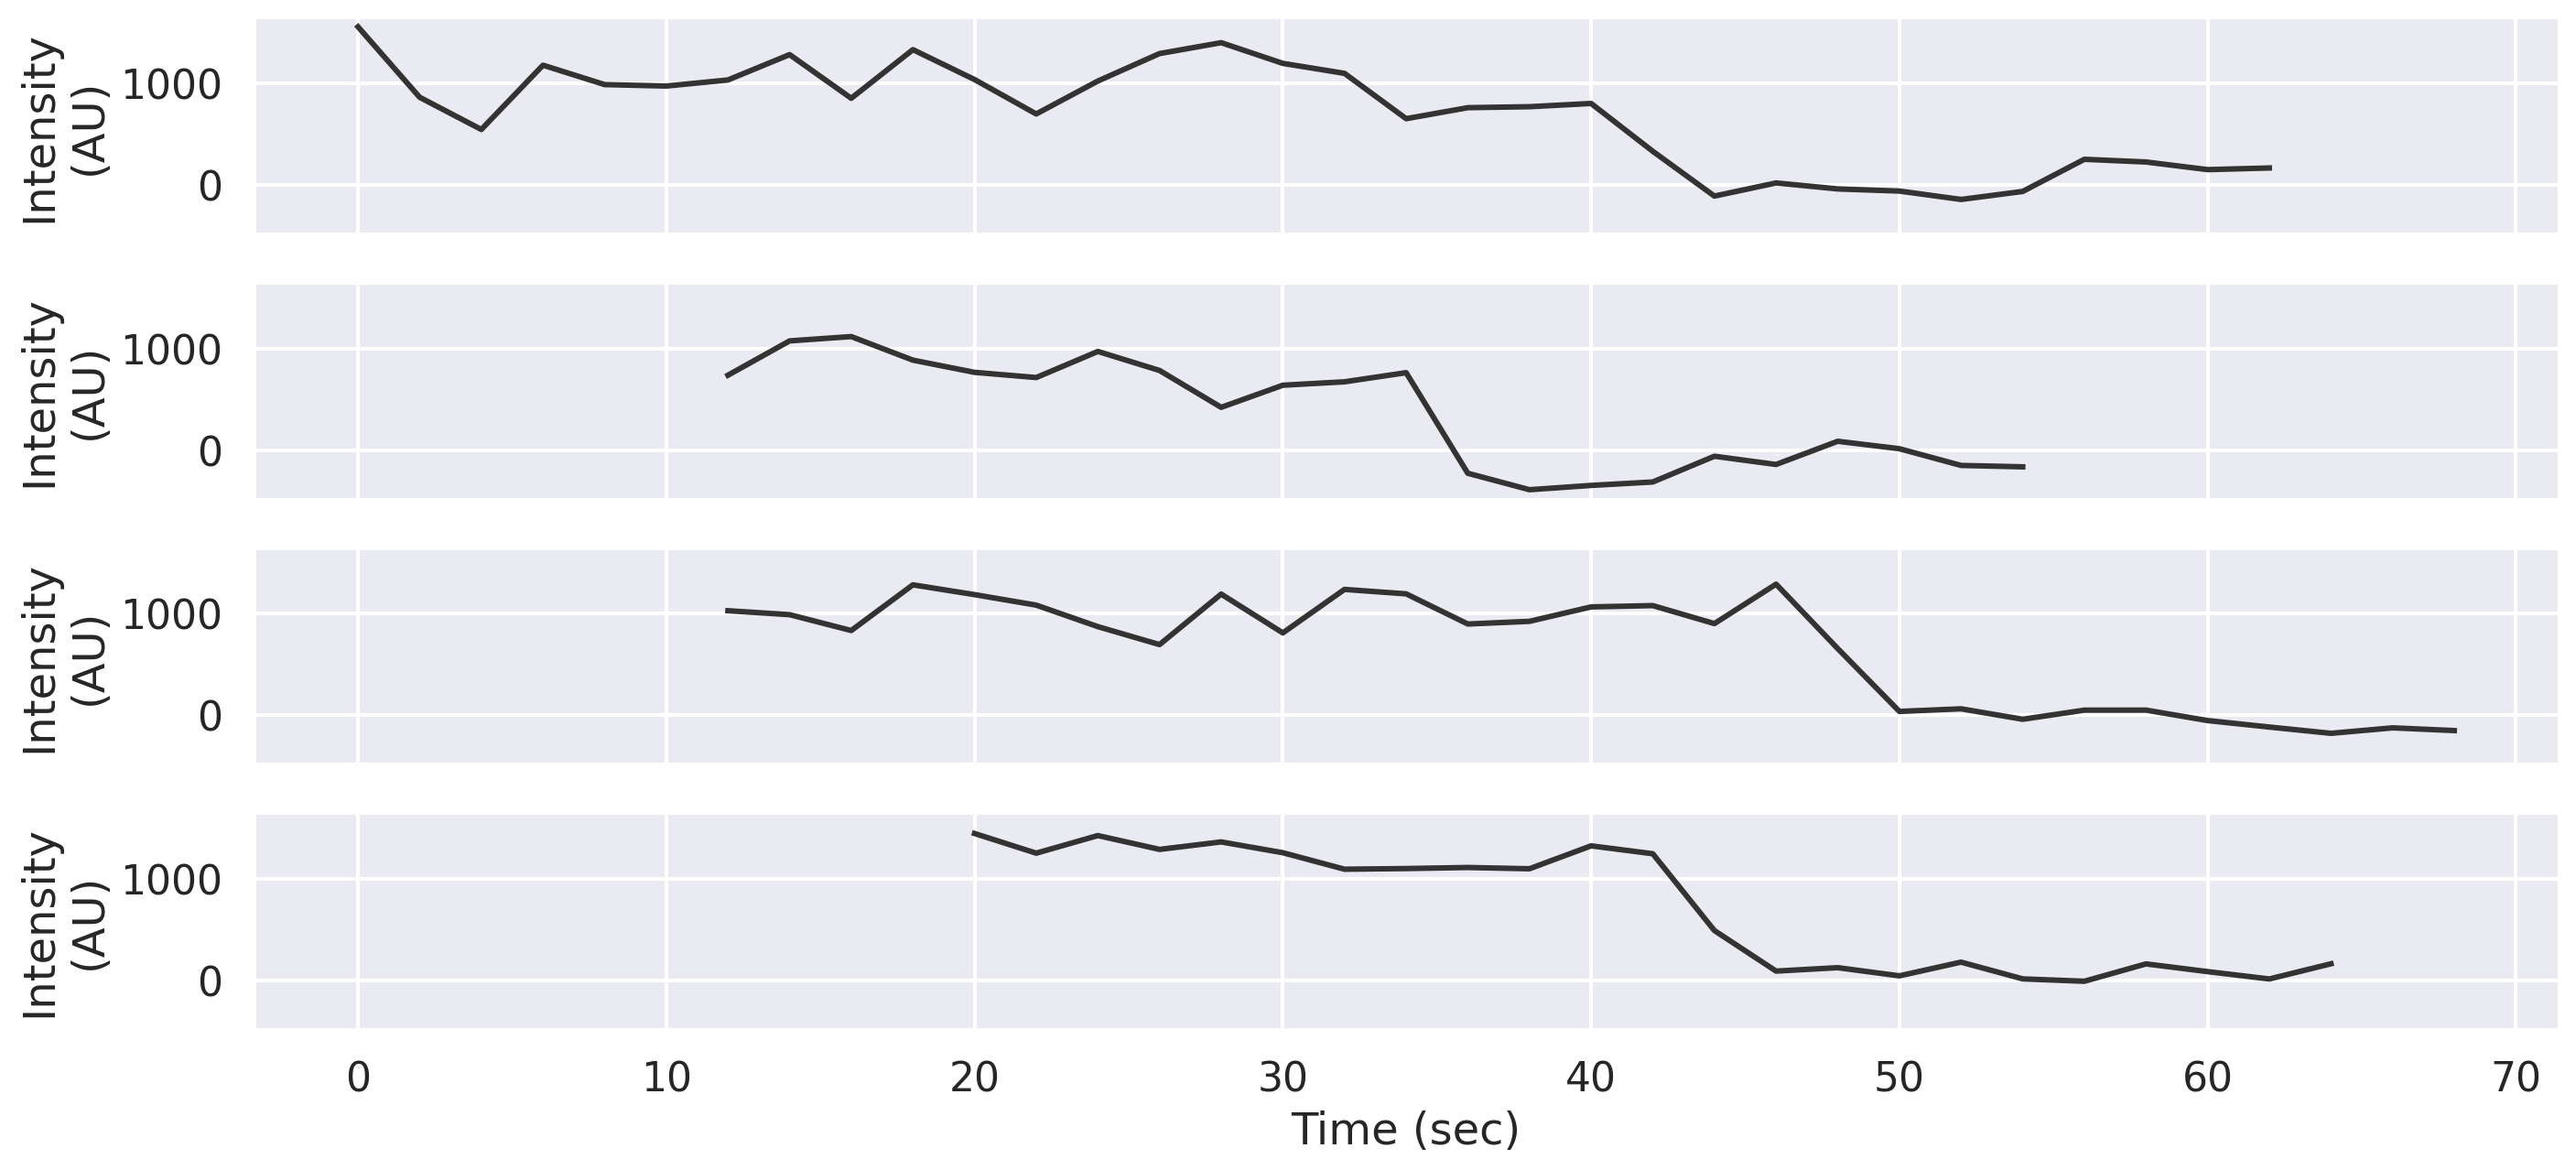

In [2]:
df = (data
      .fuse_columns(object_name='SM_traces', columns=['Dataset', 'Position', 'TrackHeadIndices'], new='spotID')
      .split_column(object_name='SM_traces', col='Indices', new_cols=['Frame', 'Cell', 'Idx'], delimiter='-')
      .SM_traces
      .assign(Cell=lambda df: df.Cell.astype('int'),
              Frame=lambda df: df.Frame.astype('int')
              )
      [['Dataset', 'PositionIdx', 'RecB_intensity', 'TrackLength', 'spotID', 'Frame', 'Cell', 'TrackHeadIndices']]
      .merge(data.Bacteria_large[['Dataset', 'PositionIdx', 'Idx', 'Frame', 'RecBIntensity']],
             suffixes=(None, '_tmp'),
             left_on=['Dataset', 'PositionIdx', 'Cell', 'Frame'],
             right_on=['Dataset', 'PositionIdx', 'Idx', 'Frame']
             )
      .assign(SNR=lambda df: df.RecB_intensity - df.RecBIntensity,
              Time=lambda df: df.Frame*2
              )
      .query('TrackLength >= 20 and PositionIdx == 2')
      .query('TrackHeadIndices != "23-15-0" and TrackHeadIndices != "24-4-0"')
      )

(
    so.Plot(df, x='Time', y='SNR', group='spotID')
    .layout(size=(15,7))
    .facet(row='TrackHeadIndices')
    .add(so.Lines(color='.2'), legend=False)
    .limit(y=(None, None))
    .label(x='Time (sec)', y='Intensity\n(AU)', title='')
    .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/SM_traces.svg', format='svg', bbox_inches='tight')
)

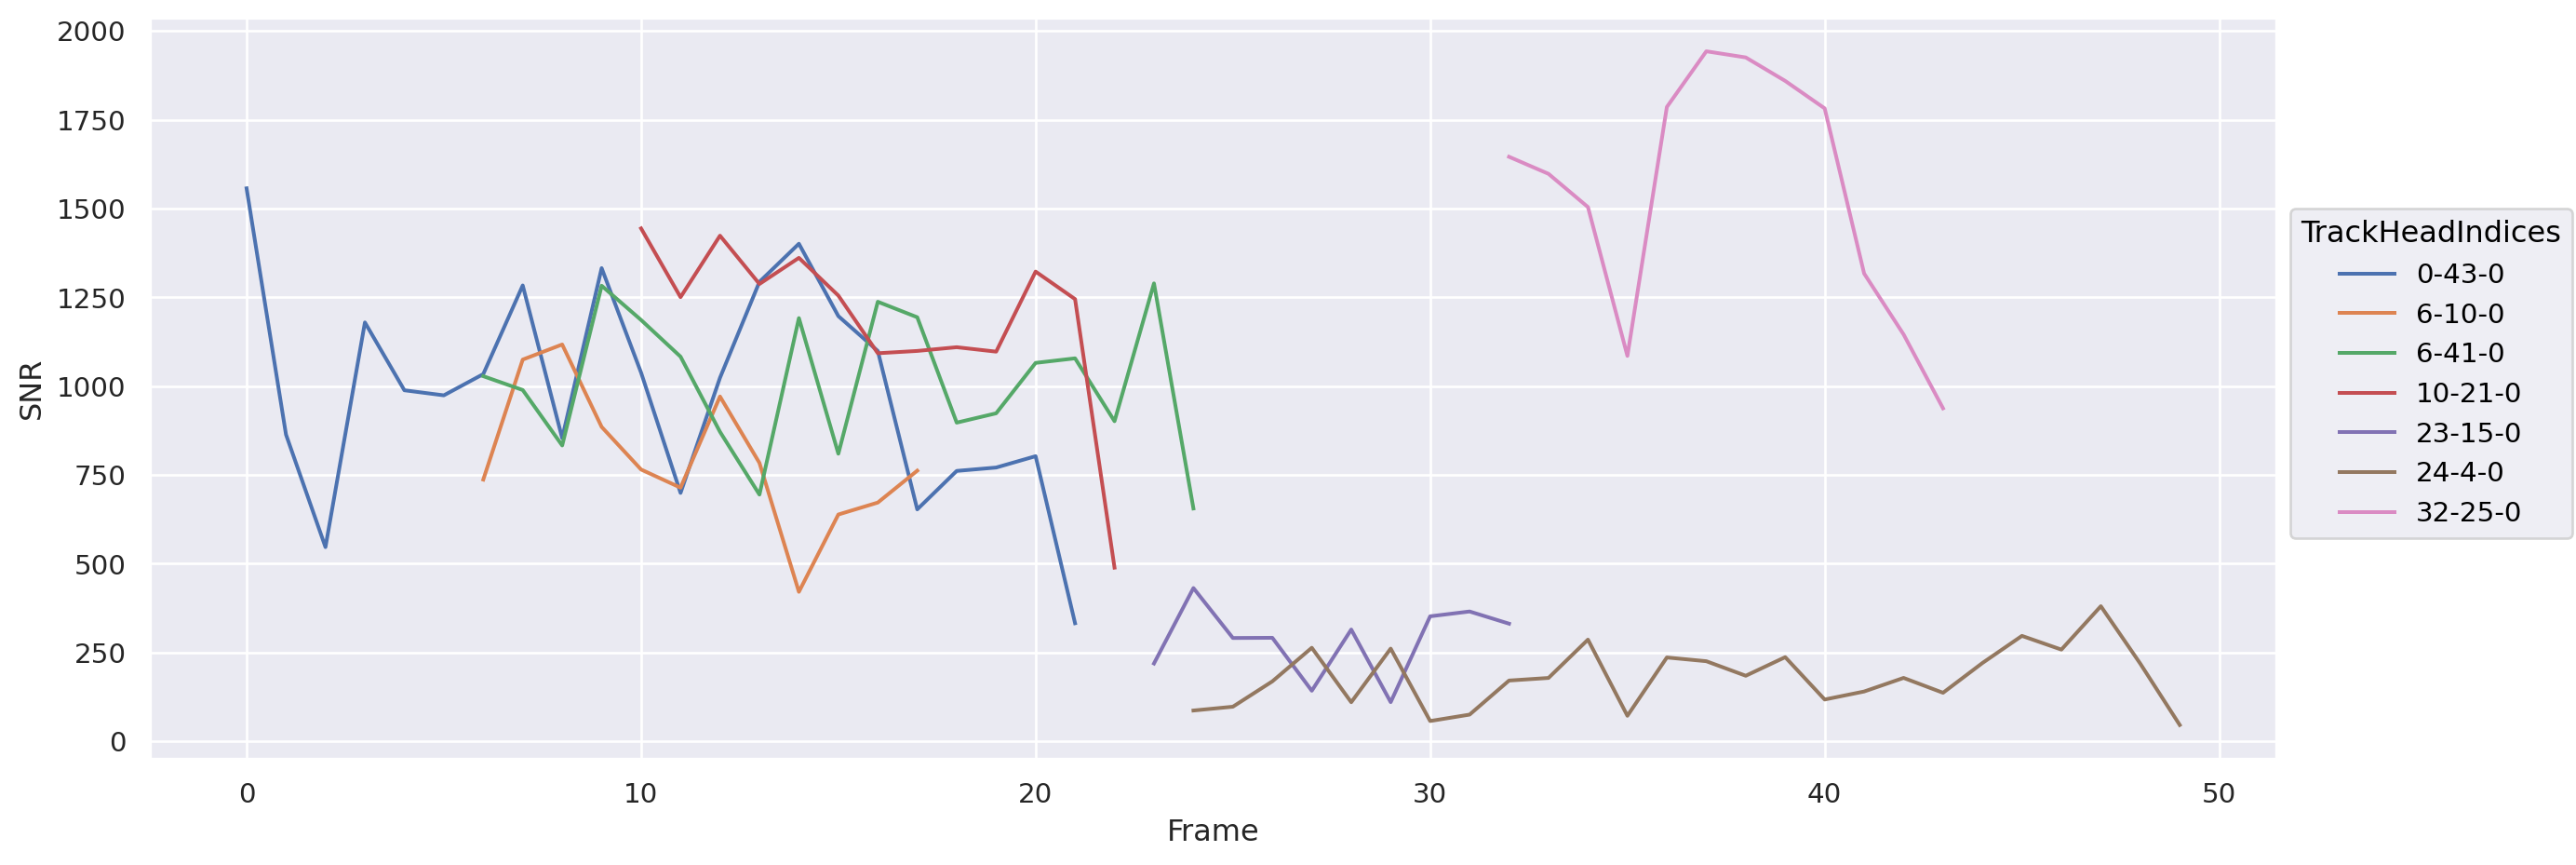

In [59]:
df = (data
      .fuse_columns(object_name='RecB_spots', columns=['Dataset', 'Position', 'TrackHeadIndices'], new='spotID')
      .split_column(object_name='RecB_spots', col='Indices', new_cols=['Frame', 'Cell', 'Idx'], delimiter='-')
    #   .add_from_parent(object_name='RecB_spots', col='RecBIntensity')
      .RecB_spots
      .assign(Cell=lambda df: df.Cell.astype('int'),
              Frame=lambda df: df.Frame.astype('int')
              )
      [['Dataset', 'PositionIdx', 'Raw_intensity', 'TrackLength', 'spotID', 'Frame', 'Cell', 'TrackHeadIndices']]
      .merge(data.Bacteria_large[['Dataset', 'PositionIdx', 'Idx', 'Frame', 'RecBIntensity']],
             suffixes=(None, '_tmp'),
             left_on=['Dataset', 'PositionIdx', 'Cell', 'Frame'],
             right_on=['Dataset', 'PositionIdx', 'Idx', 'Frame']
             )
      # .transform(lambda df: df.loc[:, ~df.columns.str.contains('_tmp')])
      .query('TrackLength >= 10 and PositionIdx == 2')
      # .query('TrackHeadIndices == "0-42-0"')
      .assign(SNR=lambda df: df.Raw_intensity - df.RecBIntensity)
      )

# display(df)

(
    so.Plot(df, x='Frame', y='SNR', group='spotID', color='TrackHeadIndices')
    .layout(size=(13,5))
    .add(so.Lines())
    .limit(y=(None, None))
)